## Name : Varun Sriram 

Approach : 
In this project, to pick the best 5 posts to portray as the top post,
I will be implementing a rating system (my own) to choose the top 5.
These are the steps:
1. Reading the dataset
2. Exploratory Analysis of the datasets / initial data cleaning
3. Creating functions required for data transformation and feature engineering
4. Developing the rating system
5. Data Transformation and feature engineering
6. Data cleaning / Polishing the dataset
7. Get the rating for insta posts 
8. Choosing the top 5 posts

### Rating system approach:
#### Each post has a caption and comments
#### We will attempt to rate the each post by finding the semantic similarity between caption and each post using vader and cosine normalization
#### We will individually rate each caption's and comments'  sentiment and using vader
####  There will be a trend where users with more followers will have more likes and comments which will give those posts an upper hand over posts/users with lesser followers
#### We will compute a balancing factor to multiply with the sentiment + similarity ratings that will normalize the final rating values



## PS: I also created an object detection program that identifies object from respective instagram posts and add it as a feature to the similarity calculation. It is in the file obj_detector.ipynb attached to the zip. But half of the filtered images were Forbidden so I chose to not use it. I have executed the script and the indentified images are in a .txt file 'detected_images.txt' and the folder detected_images holds new images that have objs detected using bounding box. 

In [1]:
# importing libraries that we know we'll need from the get-go
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

## Reading the dataset:

In [2]:
# importing the csvs
hash_tags_appreances = pd.read_csv('hashtag_top_appearances.csv')
post_data = pd.read_csv('post_metrics_and_comments.csv')
raw_post_metrics = pd.read_csv('raw_post_metrics.csv')

In [3]:
hash_tags_appreances.head()

,post_url,days_in_hashtag_top_section
0,https://www.instagram.com/p/B-zJQlUI6uN/,38
1,https://www.instagram.com/p/B-cuVYrJncn/,36
2,https://www.instagram.com/p/B_CHJzXDeNF/,33
3,https://www.instagram.com/p/B-_07jGpiWT/,29
4,https://www.instagram.com/p/B-xB_snKjld/,29


In [4]:
post_data.head()

,post_url,username,date_posted,img_urls,caption,max_likes,max_comments,max_views,followers,following,concatenated_comments
0,https://www.instagram.com/p/B-y2oOeDpj2/,064_steady,2020-04-10,{https://finesse-instagram-post-images.s3-us-w...,온라인개학으로 아침마다 아이들에게 모닝콜을 해줄 수 있어서 행복합니다. 하하하하😭 ...,1019,38,NaN,8423,697,@_o9.02 가입하자 연재야😘|아고 ㅠㅠㅠㅠ 힘드실텐데 아자아자 화이팅입니다 !!...
1,https://www.instagram.com/p/B_B4e5qDtOU/,064_steady,2020-04-16,{https://finesse-instagram-post-images.s3-us-w...,2014. 04. 16. 우리 모두 웃을 수 있기를... more,1039,12,NaN,8423,697,@nam_bbs 정말요?🙌|옷입는 스타일 너무너무 멋있으세요 ☺️|코디 너무 좋아요...
2,https://www.instagram.com/p/B-3-Skoj2ub/,064_steady,2020-04-12,{https://finesse-instagram-post-images.s3-us-w...,내일이 월요일이니까 웃자😁... more,764,35,NaN,8423,697,❤️|헐 선생님....멋져요....♥️|워료일 쪼아~ 최고로 쪼아~|Very sum...
3,https://www.instagram.com/p/B_UhfCuDnJU/,064_steady,2020-04-23,{https://finesse-instagram-post-images.s3-us-w...,너무 배불러요 ㅠㅠㅠ... more,779,56,NaN,8423,697,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ배불러졌다는게 너무 웃겨욬ㅋㅋㅋㅋㅋ|깔끔한 쓰앵님🤭👍🏿|😍😍😍😍❤...
4,https://www.instagram.com/p/B-6isIeD-0-/,064_steady,2020-04-13,{https://finesse-instagram-post-images.s3-us-w...,월요병 극복🥴,733,26,NaN,8423,697,극복 나이스👍🏻|@mndp404 시간은 결국 흐르니 ㅠㅠ|내일도 화요팅~!|@yeo...


In [5]:
raw_post_metrics.head()

,post_url,num_likes,num_comments,num_views,date_time_collected
0,https://www.instagram.com/p/B_PNBlGDTYQ/,647,15,NaN,2020-04-21 21:00:41
1,https://www.instagram.com/p/B-jWhHKjDsa/,925,105,NaN,2020-04-21 21:11:39
2,https://www.instagram.com/p/B-eNiazDOXp/,987,73,NaN,2020-04-21 21:11:42
3,https://www.instagram.com/p/B-oswDhDUB4/,960,73,NaN,2020-04-21 21:11:47
4,https://www.instagram.com/p/B-rM41AD62p/,715,67,NaN,2020-04-21 21:11:49


In [6]:
# Finding na's
post_data.isna().sum()
# max_views is only for videos and is primarily NaN, so it safe to get rid rid of it. In my opinion,
# if image posts had views, it would play a big role in our objective
post_data.drop('max_views', axis=1, inplace=True)

In [7]:
post_data.head()
post_data.describe()

,max_likes,max_comments,followers,following
count,1.163700e+04,11637.000000,1.163700e+04,11637.000000
mean,3.562104e+04,324.792214,1.243899e+06,982.605311
std,3.018051e+05,3817.158997,9.727885e+06,1191.510011
min,0.000000e+00,0.000000,1.070000e+02,0.000000
25%,7.380000e+02,13.000000,1.520000e+04,281.000000
50%,1.773000e+03,38.000000,4.900000e+04,664.000000
75%,5.371000e+03,103.000000,1.810000e+05,1125.000000
max,1.102544e+07,214008.000000,1.900000e+08,7562.000000


In [8]:
# Function to create histograms and box plots
def histogram_plot(df, col_name):
    plt.figure(figsize=(20,10))
    sns.distplot(df[col_name], color="dodgerblue",\
                  kde_kws={"color": "b", "lw": 1, "label": "KDE"},\
                  hist_kws={"linewidth": 3})  
    plt.legend()
    plt.show()
    
def box_plot(df, col_name):
    plt.figure(figsize=(1,3), dpi = 180)
    sns.boxplot(df[col_name], orient = 'v', color = 'black', fliersize = 0.5, linewidth = 0.5)
    plt.show()

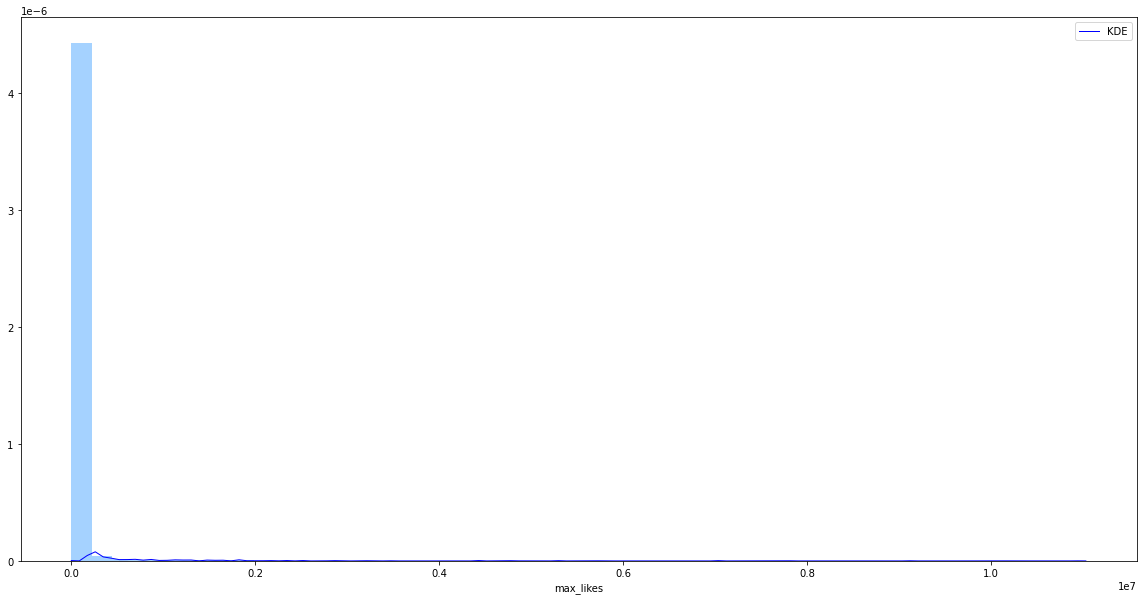

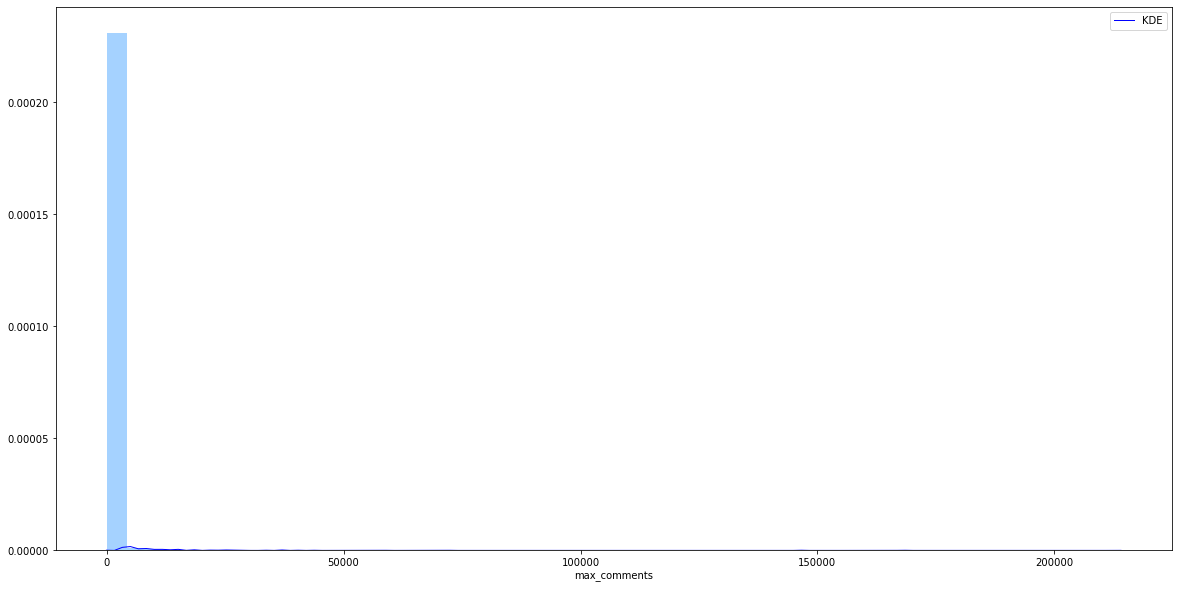

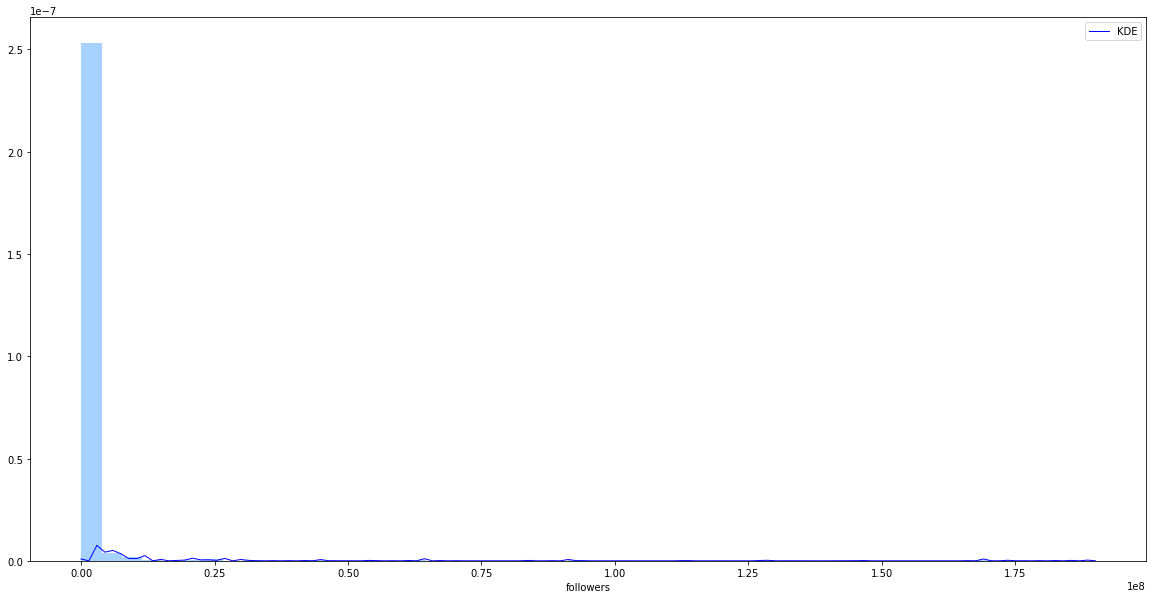

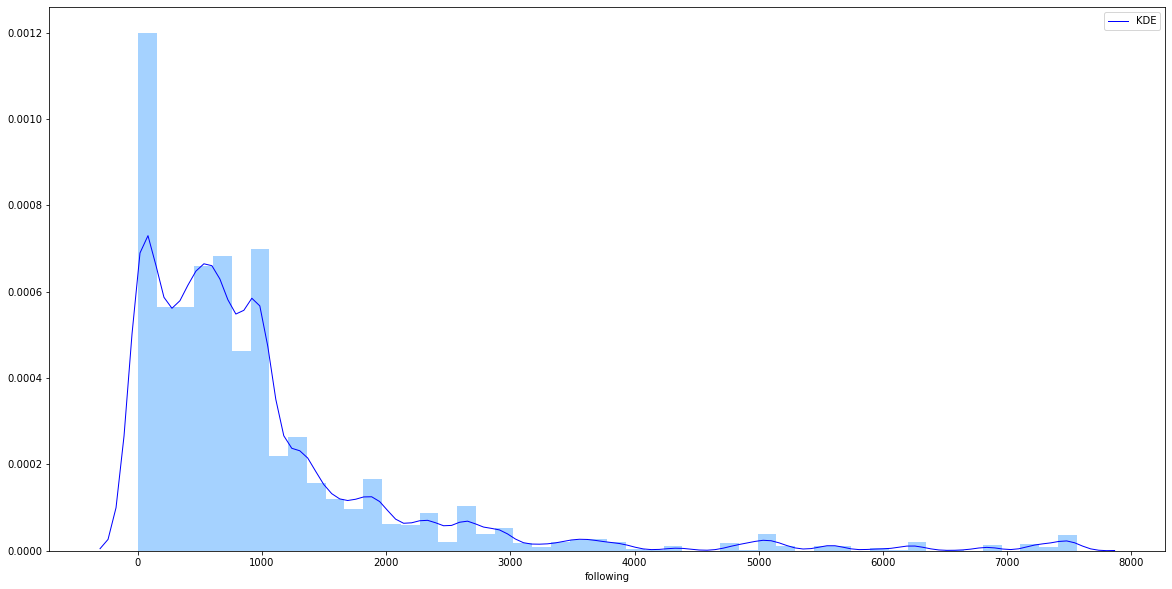

In [9]:
histogram_plot(post_data, 'max_likes')
histogram_plot(post_data, 'max_comments')
histogram_plot(post_data, 'followers')
histogram_plot(post_data, 'following')

## As we can see in the above graphs, they are majorly skewed right, when it comes to following, followers, likes etc. Since, the rating system will give an advantage to posts with higher valued attributes, we will formulate a balancing factor based on likes and followers later. 

## This will is a core game design principle to prevent better team (posts in this situation) to get the upper hand. 

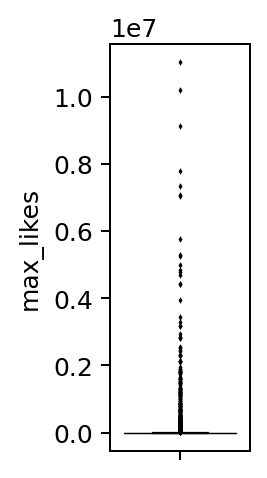

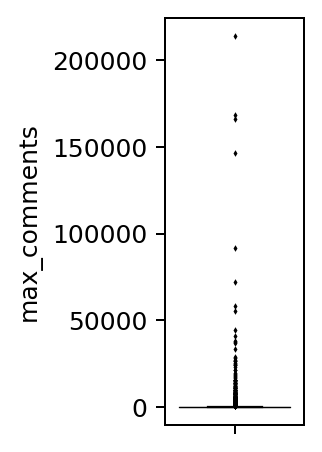

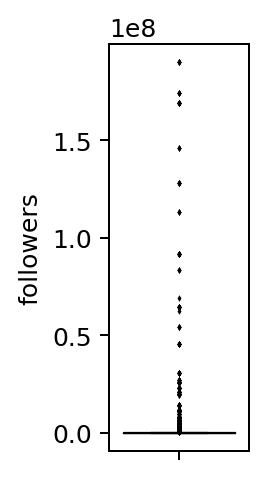

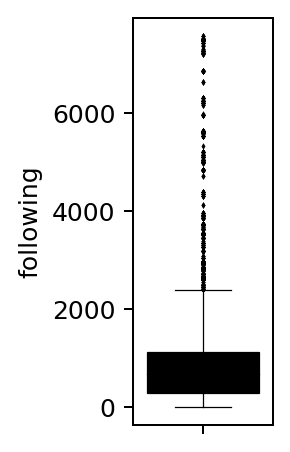

In [10]:
box_plot(post_data, 'max_likes')
box_plot(post_data, 'max_comments')
box_plot(post_data, 'followers')
box_plot(post_data, 'following')

## Setting up some functions needed for feature engineering and data transformation
## Developing the rating system

In [11]:
# Creating a list of emojis and compiling them
import emoji
emoji_list = [e for e in emoji.UNICODE_EMOJI]

In [12]:
import regex
import emoji
import re
import demoji

"""
A helper function to extract emojis. Depending on the flag 'remove', the return type  is a
list of emojis extracted from the text or text without emojis
"""
        
def extract_emojis(text, remove = False):
    if not remove:
        a = demoji.findall(text)
        ans = [key for key in a.keys()]
        return ans
    
    else:
        emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
        return re.sub(emoj, '', text)

In [13]:
"""
A helper function to check if input text is english. If is_list is false, the function
will work on a single string sentence else, on a list of strings.

Input params: text, bool is_list
Output: if is_list is false, single True/False value
        if is_list is true, list of True/False
"""
from langid import classify


def detect_filter_lang(text, is_list = False):
    if not is_list:
        ans = classify(text)
        lang, prob = ans
        if lang == 'en':
            return True
        else:
            return False
    
    else:
        ans = []
        for x in text:
            temp = classify(text)
            lang, prob = temp
        if lang == 'en':
            ans.append(True)
        else:
            ans.append(False)
        return ans

In [14]:
"""
We are choosing random _ number of comments of the post to compute the rating
because computing power issues.

input params: list of sentences
output : a list containing n sentences
"""
def pick_lottery(texts):
    
    num_selections = 5
    new_list = random.sample(texts, num_selections)
    
    return new_list

In [15]:
"""
From the nltk library, vader will help us sentiment score the input text. Text can include or 
only be emojis
"""
import nltk
nltk.download('vader_lexicon')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def get_sentiment_score(text):    
    sid = SentimentIntensityAnalyzer()
    scores = sid.polarity_scores(text)
    return scores['compound']

[nltk_data] Downloading package vader_lexicon to C:\Users\Varun
[nltk_data]     Panda\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [16]:
"""
A function to determine how the comments are related to the posts.
"""
from collections import defaultdict
from gensim import corpora
from gensim import models
from gensim import similarities
def calc_similarities(corpus, query):
    stoplist = set('for a of the and to in'.split())
    texts = [
        [word for word in corpi.lower().split() if word not in stoplist]
        for corpi in corpus
            ]

    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=2)  
    vec_bow = dictionary.doc2bow(query.lower().split())
    vec_lsi = lsi[vec_bow]  # convert the query to LSI space
    index = similarities.MatrixSimilarity(lsi[corpus])  # transform corpus to LSI space and index it    
    index.save('temp.index')
    index = similarities.Similarity.load('temp.index')
    sims = index[vec_lsi]
    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    return sims

In [17]:
"""
Function that accepts a caption, and a comment and returns a semantic similarity value using
cosine vectorization. I am using a sparse matrix here because it saves a huge amount of space
"""
from sklearn.feature_extraction.text import TfidfVectorizer
def similarity(caption, text):

    similarity_scores = []
    
    corpus = [caption, text]
    vect = TfidfVectorizer(min_df = 1, stop_words="english")
    try:
        tfidf = vect.fit_transform(corpus)
    except ValueError as e:
        print(e)
        return 0
    pairwise_similarity = tfidf * tfidf.T 
    sparse_matrix = pairwise_similarity.toarray()
    
    return sparse_matrix[0][1]


In [18]:
"""
Function to calculate the final rating.
(post_likes/followers) - (max_post_likes/followers) / (max_post_likes/followers)
"""
def get_final_rating(current_val):
    likes_factor = (current_val - new_post_data['max_likes'].max()) / new_post_data['max_likes'].max()
    followers_factor = (current_val - new_post_data['followers'].max()) / new_post_data['followers'].max()
    
    final_rating = current_val + likes_factor + followers_factor
    return final_rating

## Feature engineering

In [19]:
new_post_data = post_data

# Adding new columns to the dataframe
new_post_data['caption_text'] = '' # Column for caption w/o emojis
new_post_data['caption_emojis'] = '' # Column to hold caption emojis
new_post_data['caption_is_english'] = None # Check if caption is in english
new_post_data['caption_combined_score'] = 0.0
new_post_data['comment_text'] = '' # Column for comments w/o emojis
new_post_data['comment_emojis'] = '' # Column to hold comment emojis
new_post_data['comment_senti_score'] = 0.0 # Column to hold comments' setiment score 
new_post_data['comment_emoji_score'] = 0.0 # Column to hold emoji's setiment score 
new_post_data['comment_combined_score'] = 0.0 # Combined score of comment and emoji
new_post_data['similarity_scores'] = 0.0 # Similarity scores dor cooment and caption
new_post_data['final_ratings'] = 0.0

## We are going to drop rows/posts that fall below the 0.25 percentile based on likes and followers

In [20]:
lower_quantile_likes, upper_quantile_likes = new_post_data.max_likes.quantile([.25, .75])
new_post_data = new_post_data.loc[(new_post_data.max_likes > lower_quantile_likes)]
lower_quantile_followers, upper_quantile_followers = new_post_data.followers.quantile([.25, .75])
new_post_data = new_post_data.loc[(new_post_data.followers > lower_quantile_followers)]

## Feature engineering 

In [21]:
# Separating text from the caption
new_post_data['caption_text'] = new_post_data['caption'].\
                                    map(lambda a:extract_emojis(str(a), remove =True))

In [22]:
# Extracting emojis from the caption
new_post_data['caption_emojis'] = new_post_data['caption'].\
                                            map(lambda a:extract_emojis(str(a), remove =False))

In [23]:
# Checking if caption is only english 
new_post_data['caption_is_english'] = new_post_data['caption_text'].\
                                              map(lambda a: detect_filter_lang(str(a), is_list = False))

# Filtering out non english posts because of computation issues
new_post_data = new_post_data[new_post_data.caption_is_english == True]

In [24]:
# Splitting the concatenated comments into a list of comments
separated_comments =  post_data['concatenated_comments'].map(lambda a: str(a).split('|'))

In [25]:
# Filtering and removing emojis and from the comments into separate columns

comments_text = separated_comments.map(lambda a:extract_emojis(str(a), remove =True))
comments_emojis = separated_comments.map(lambda a:extract_emojis(str(a), remove =False))
new_post_data['comment_text'] = comments_text
new_post_data['comment_emojis'] = comments_emojis

In [26]:
# Reading from .csv creates a pandas"Series" dtype obj. We will convert them to list while
# removing some unnecessary '\' and '[' in the process

final_comment_list = []

for index_, val in new_post_data['comment_text'].iteritems():
    re.sub('[^A-Za-z0-9]+', '', val)

for val in new_post_data['comment_text']:
    final_comment_list.append(val.strip('][').split(', ') )

    


In [27]:
print(new_post_data['caption_text'])

19                                    Wave Check! ... more
20       I used to here “this boy is so into himself......
22       My Daughter is a Diva for this pic! Lol I wish...
24                  LIKE = GOOD LUCK FOR THE REST OF 2020 
25                                  Nothing really matters
                               ...                        
11627                                               Exhale
11631    I  beautiful Amber @ambervalletta in @ysl styl...
11632    Gorgeous sweet Angel @dualipa for @elleusa  th...
11633     @dualipa who is the sweetest, talented icon f...
11634    One of my favorite outtakes of beautiful @hail...
Name: caption_text, Length: 5300, dtype: object


In [28]:
# Same for caption
for index_, val  in new_post_data['caption_text'].iteritems():
    re.sub('[^A-Za-z0-9]+', '', val)

final_caption_list = []
for val in new_post_data['caption_text']:
    final_caption_list.append(val.strip('][').split(', ') )

In [29]:
# Removing blank values
final_caption_list = [x[0] for x in final_caption_list if len(x[0]) > 10] 
final_comment_list = [x for x in list(final_comment_list) if len(x) > 5]

In [30]:
# Due to system computation issues, I am forced to choose the top best 10 comments from the 
# comments section
final_comment_list = [x[0:15] for x in final_comment_list]

In [31]:
new_post_data.to_csv('final_dataset.csv')

## Rating system:
### Here we are rating each post's caption and their respective comments' text and emoji separately and add them via sentiment analysis. Thei way we can check the magnitude of impact they have. 

### Positive Impact is directly proportional to the score returned

In [32]:
# Calculating sentiment scores for caption texts
c_scores = [] # Caption text
e_scores = [] # Caption emojis
for text in final_caption_list:
    temp = []
    for mess in text:
        temp.append(get_sentiment_score(mess))
    c_scores.append(temp)



# Calculating sentiment scores for comment texts

co_scores = [] # Comment text
ce_scores = [] # Comment emojis
for text in final_comment_list:
    temp = []
    for mess in text:
        temp.append(get_sentiment_score(mess))
    co_scores.append(temp)



In [33]:
for x in new_post_data['caption_emojis']:
    temp = []
    for y in x:
        temp.append(get_sentiment_score(str(y)))
    
    e_scores.append(temp)

In [34]:
for x in new_post_data['comment_emojis']:
    temp = []
    for y in x:
        temp.append(get_sentiment_score(str(y)))
    
    ce_scores.append(temp)

In [35]:
# Adding all caption text scores 
c_scores = [sum(score) for score in c_scores] 

In [36]:
np.shape(new_post_data)

(5300, 21)

In [37]:
# Adding all caption emoji scores
e_scores = [sum(scores) for scores in e_scores]

In [38]:
# Adding comment emojis scores
ce_scores = [sum(scores) for scores in ce_scores]

In [39]:
# Adding respective text and emoji scores for caption and comment
caption_combined_scores = c_scores + e_scores
comment_combined_scores = ce_scores + co_scores

In [40]:
new_post_data['caption_combined_score'] = pd.Series(caption_combined_scores)

In [41]:
new_post_data['comment_combined_score'] = pd.Series(caption_combined_scores)

In [42]:
new_post_data.head()

,post_url,username,date_posted,img_urls,caption,max_likes,max_comments,followers,following,concatenated_comments,...,caption_emojis,caption_is_english,caption_combined_score,comment_text,comment_emojis,comment_senti_score,comment_emoji_score,comment_combined_score,similarity_scores,final_ratings
19,https://www.instagram.com/p/B_ORnUmDkSr/,360jeezy,2020-04-21,{https://finesse-instagram-post-images.s3-us-w...,Wave Check! ... more,8592,169,651000,299,I love this wavy sh!t|@wolfjaegger mercy but h...,...,[],True,0.0000,"['I love this wavy sh!t', '@wolfjaegger mercy ...","[🌶, 💪🏿, 🤦, 🙏🏾, 💀, 🌊, 🤦🏽, 💧, 🤣, 🐐, 🤕, ⛵, 🔥, 💨, ...",0.0,0.0,0.0000,0.0,0.0
20,https://www.instagram.com/p/B-9wjdVDvto/,360jeezy,2020-04-14,{https://finesse-instagram-post-images.s3-us-w...,I used to here “this boy is so into himself......,7089,85,651000,299,ᖴᗩᑕTᔕ ᗷᖇO🌀🌀🌀|🔥🔥🔥🔥🔥🔥💯|Yup jeezy only you Gon se...,...,[],True,0.0000,"['ᖴᗩᑕTᔕ ᗷᖇO', '', 'Yup jeezy only you Gon see ...","[🏄, 💻, 💪🏿, 🎌, 😈, 📩, 💀, 🌊, 🎒, 🤞🏽, 🤔, 👍, 🙌🏾, 👨, ...",0.0,0.0,0.0000,0.0,0.0
22,https://www.instagram.com/p/B-2WdMdjAuT/,360jeezy,2020-04-11,{https://finesse-instagram-post-images.s3-us-w...,My Daughter is a Diva for this pic! Lol I wish...,5951,35,651000,299,❤️❤️❤️|❤️❤️❤️|❤️❤️❤️|❤️❤️❤️|❤️❤️❤️|Cutie pie.....,...,[🌠],True,3.6704,"['', '', '', '', '', 'Cutie pie... get ya shot...","[🙌, 💞, 🔥, 💯, ✨, 💖, 😍, 🌠, 🤣, 💪, ❤️]",0.0,0.0,3.6704,0.0,0.0
24,https://www.instagram.com/p/B-5psGjljUn/,60secgang,2020-04-13,{https://finesse-instagram-post-images.s3-us-w...,LIKE = GOOD LUCK FOR THE REST OF 2020 🤣,877,6,84200,1917,LIKE = GOOD LUCK FOR THE REST OF 2020 🤣|Facts|...,...,[🤣],True,0.4588,"['LIKE = GOOD LUCK FOR THE REST OF 2020 ', 'Fa...","[🕊, 🔥, 🖤, 🤣]",0.0,0.0,0.4588,0.0,0.0
25,https://www.instagram.com/p/B_Inj4KjckC/,70s.vogue,2020-04-18,{https://finesse-instagram-post-images.s3-us-w...,Nothing really matters,4390,33,91500,446,🔥|Fr|but the Prada bucket hat does...|Bob hat|...,...,[],True,0.0000,"['', 'Fr', 'but the Prada bucket hat does...',...","[🍦, 🤠, 😻, 🔥, 💯, 💙, ❤, 💘, 😍, 💜, 🖤, 🚀, 😁, 🏼]",0.0,0.0,0.0000,0.0,0.0


In [43]:
# Calculating semantic similarity scores for a caption and their individual comments
similarity_scores = []
for i in range(len(final_caption_list)):
    temp = []
    for y in final_comment_list[i]:
        temp.append(similarity(final_caption_list[i], y))
    
    similarity_scores.append(temp)

empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

In [44]:
# Adding all semantic similarity scores 
final_similarity_score = [sum(scores) for scores in similarity_scores]

In [45]:
new_post_data['similarity_scores'] = pd.Series(final_similarity_score)

In [46]:
new_post_data['final_ratings'] = new_post_data['similarity_scores'] + \
                                    new_post_data['comment_combined_score'] + \
                                    new_post_data['caption_combined_score']


### Now we calculate the balancing factor by this formula and add it to the ratings

### (post_likes/followers) - (max_post_likes/followers) / (max_post_likes/followers)

In [47]:
# Calculating the balancing factor

new_post_data['final_ratings'] = new_post_data['final_ratings'].apply(lambda x: get_final_rating(x))


In [48]:
new_post_data.head()

,post_url,username,date_posted,img_urls,caption,max_likes,max_comments,followers,following,concatenated_comments,...,caption_emojis,caption_is_english,caption_combined_score,comment_text,comment_emojis,comment_senti_score,comment_emoji_score,comment_combined_score,similarity_scores,final_ratings
19,https://www.instagram.com/p/B_ORnUmDkSr/,360jeezy,2020-04-21,{https://finesse-instagram-post-images.s3-us-w...,Wave Check! ... more,8592,169,651000,299,I love this wavy sh!t|@wolfjaegger mercy but h...,...,[],True,0.0000,"['I love this wavy sh!t', '@wolfjaegger mercy ...","[🌶, 💪🏿, 🤦, 🙏🏾, 💀, 🌊, 🤦🏽, 💧, 🤣, 🐐, 🤕, ⛵, 🔥, 💨, ...",0.0,0.0,0.0000,0.0,-2.000000
20,https://www.instagram.com/p/B-9wjdVDvto/,360jeezy,2020-04-14,{https://finesse-instagram-post-images.s3-us-w...,I used to here “this boy is so into himself......,7089,85,651000,299,ᖴᗩᑕTᔕ ᗷᖇO🌀🌀🌀|🔥🔥🔥🔥🔥🔥💯|Yup jeezy only you Gon se...,...,[],True,0.0000,"['ᖴᗩᑕTᔕ ᗷᖇO', '', 'Yup jeezy only you Gon see ...","[🏄, 💻, 💪🏿, 🎌, 😈, 📩, 💀, 🌊, 🎒, 🤞🏽, 🤔, 👍, 🙌🏾, 👨, ...",0.0,0.0,0.0000,0.0,-2.000000
22,https://www.instagram.com/p/B-2WdMdjAuT/,360jeezy,2020-04-11,{https://finesse-instagram-post-images.s3-us-w...,My Daughter is a Diva for this pic! Lol I wish...,5951,35,651000,299,❤️❤️❤️|❤️❤️❤️|❤️❤️❤️|❤️❤️❤️|❤️❤️❤️|Cutie pie.....,...,[🌠],True,3.6704,"['', '', '', '', '', 'Cutie pie... get ya shot...","[🙌, 💞, 🔥, 💯, ✨, 💖, 😍, 🌠, 🤣, 💪, ❤️]",0.0,0.0,3.6704,0.0,5.340801
24,https://www.instagram.com/p/B-5psGjljUn/,60secgang,2020-04-13,{https://finesse-instagram-post-images.s3-us-w...,LIKE = GOOD LUCK FOR THE REST OF 2020 🤣,877,6,84200,1917,LIKE = GOOD LUCK FOR THE REST OF 2020 🤣|Facts|...,...,[🤣],True,0.4588,"['LIKE = GOOD LUCK FOR THE REST OF 2020 ', 'Fa...","[🕊, 🔥, 🖤, 🤣]",0.0,0.0,0.4588,0.0,-1.082400
25,https://www.instagram.com/p/B_Inj4KjckC/,70s.vogue,2020-04-18,{https://finesse-instagram-post-images.s3-us-w...,Nothing really matters,4390,33,91500,446,🔥|Fr|but the Prada bucket hat does...|Bob hat|...,...,[],True,0.0000,"['', 'Fr', 'but the Prada bucket hat does...',...","[🍦, 🤠, 😻, 🔥, 💯, 💙, ❤, 💘, 😍, 💜, 🖤, 🚀, 😁, 🏼]",0.0,0.0,0.0000,0.0,-2.000000


In [52]:
new_post_data.sort_values(by=['final_ratings'], ascending=False, inplace=True)

In [53]:
top_5 = []
top_5.append(new_post_data[0:5])


In [54]:
top_5

[                                      post_url         username date_posted  \
 3295  https://www.instagram.com/p/B-4kGSSha9-/    maikeeb_kills  2020-04-12   
 3198  https://www.instagram.com/p/B-tedjOBhw9/      luckyoetama  2020-04-08   
 1033  https://www.instagram.com/p/B-2p5BVn8kY/       culturfits  2020-04-11   
 4178  https://www.instagram.com/p/B_KYr1_JkZR/       purplerang  2020-04-19   
 1399  https://www.instagram.com/p/B-pdqrGJKx4/  eaststreetwear_  2020-04-06   
 
                                                img_urls  \
 3295  {https://finesse-instagram-post-images.s3-us-w...   
 3198  {https://finesse-instagram-post-images.s3-us-w...   
 1033  {https://finesse-instagram-post-images.s3-us-w...   
 4178  {https://finesse-instagram-post-images.s3-us-w...   
 1399  {https://finesse-instagram-post-images.s3-us-w...   
 
                                                 caption  max_likes  \
 3295  Happy easter y’all..... last year on easter we...       7509   
 3198  Contras

### There you have it, top 5 posts from the dataset

### What more I can do further:
#### use other languages, translate them and use them in sentiment analysis
#### Use the detected objs from the obj detector and use them in alaysis
#### Make the model accept a set of keywords which could be used to filter out top posts related to those keywords, keywords being hashtags. For example find top posts for #footwear, so posts only related to footwear will be selected. This could be achieved by identifying all the synonyms of 'footwear' adding them to the corpus and then comparing using semantic analysis.